In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise, InputLayer, Lambda
from keras import backend as K

In [29]:
k = 2
n = 2
M = 2 ** k
R = k * 1. / n
training_snr_db = np.array([3.0, 7.0, 8.0])
training_snr_linear = 10 ** training_snr_db / 10
training_sigma2 = 1. / (2 * R * training_snr_linear)

In [30]:
class AutoEncoder(tf.keras.Model):
    def __init__(self, M, n, sigma2, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)

        self.sigma = np.sqrt(np.array(sigma2))
        self.transmitter = Sequential([
                                InputLayer(input_shape=(M,)),
                                Dense(M, activation='ReLU', use_bias=True),
                                Dense(n, activation='linear', use_bias=True),
                                Lambda(lambda obs: tf.math.sqrt(n * 1.0) *
                                              K.l2_normalize(obs, axis=1
                                                             ))
        ])

        self.receiver = Sequential([
                                Dense(M, activation='ReLU', use_bias=True),
                                Dense(M, activation='softmax', use_bias=True)
        ])

    def call(self, inputs):
        z = self.transmitter(inputs)
        what_snr = np.random.choice(np.arange(len(self.sigma)), size=1)
        chann = GaussianNoise(stddev=self.sigma[what_snr])
        z = chann(z)
        z = self.receiver(z)
        return z

In [31]:
n_samples = 200000
X_train = np.eye(M)[np.random.choice(M, n_samples)]
Y_train = X_train.copy()

In [32]:
batch_size = 256
n_epochs = 100

In [33]:
model = AutoEncoder(M, n, training_sigma2)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
history = model.fit(x=X_train,
                    y=Y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_split=0.1)

Epoch 1/100
704/704 [==============================] - 2s 2ms/step - loss: 0.6779 - accuracy: 0.8641 - val_loss: 0.1810 - val_accuracy: 1.0000
Epoch 2/100
704/704 [==============================] - 1s 2ms/step - loss: 0.0670 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 3/100
704/704 [==============================] - 1s 1ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 4/100
704/704 [==============================] - 1s 2ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 5/100
704/704 [==============================] - 1s 2ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 6/100
704/704 [==============================] - 1s 2ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/100
704/704 [==============================] - 1s 1ms/step - loss: 9.8461e-04 - accuracy: 1.0000 - val_loss: 7.6385e-04 - val_accuracy

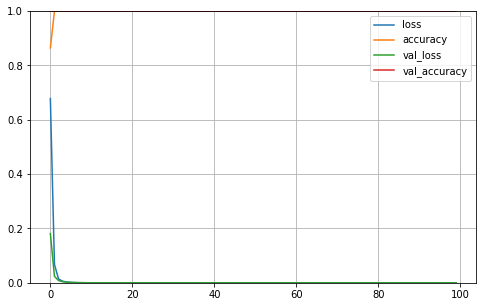

In [35]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig('history.jpg')
plt.show()

In [36]:
snr_vec_db = np.linspace(-2, 10, 20)
snr_vec = 10. ** (snr_vec_db / 10)
sigma2_vec = 1. / (2 * R * snr_vec)
bler_autoencoder = np.zeros(sigma2_vec.shape)
X_test = np.eye(M)[np.random.choice(M, n_samples * 10)]
Y_test = X_test.copy()

In [37]:
for i in range(len(sigma2_vec)):
    x = model.transmitter(X_test)
    y = x + tf.random.normal(x.shape, mean=0.0, stddev=sigma2_vec[i] ** 0.5)
    s_pred = np.array(model.receiver(y))
    bler_autoencoder[i] = np.sum(s_pred.argmax(axis=1) != Y_test.argmax(axis=1)) / Y_test.shape[0]

In [38]:
bler_uncodedBPSK = [2.43746667e-01, 2.12800000e-01, 1.84053333e-01,
                    1.55770000e-01, 1.29110000e-01, 1.02463333e-01,
                    8.01300000e-02, 6.08866667e-02, 4.36866667e-02,
                    3.02933333e-02, 1.97366667e-02, 1.24433333e-02,
                    7.16333333e-03, 3.99000000e-03, 1.84666667e-03,
                    8.13333333e-04, 3.00000000e-04, 1.20000000e-04,
                    4.66666667e-05, 1.33333333e-05]

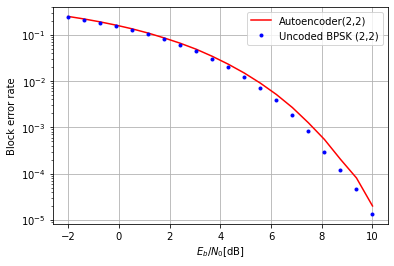

In [39]:
plt.figure()
plt.semilogy(snr_vec_db, bler_autoencoder, 'r', label="Autoencoder(2,2)")
plt.semilogy(snr_vec_db, bler_uncodedBPSK, 'b.', label="Uncoded BPSK (2,2)")
plt.grid(True)
plt.ylabel("Block error rate")
plt.xlabel("$E_b/N_0$[dB]")
plt.legend()
plt.savefig('bler.jpg')
plt.show()

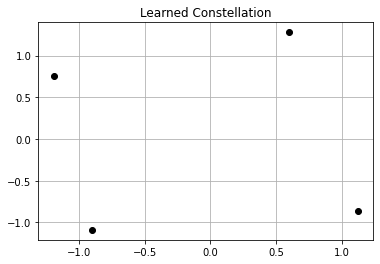

In [40]:
# Valid Only for n = 2
if n == 2:
    symbols = np.eye(M)
    x = model.transmitter(symbols)

    plt.figure()
    plt.scatter(x[:, 0], x[:, 1], color="black")
    plt.title("Learned Constellation")
    plt.grid()
    plt.savefig('constellation.jpg')
    plt.show()
else:
    pass